<a href="https://colab.research.google.com/github/anshid/python-projects/blob/main/Games_Lab_Crash_Course_AI_13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Build the game environment

Artificial intelligence agents can be taught to play games through trial and error. Games test many parts of human intelligence like strategy, learning, intuition, and reflex, which is why playing Chess or Go are huge challenges in the field of AI.

The objective of this lab is to is to teach an AI system to play a game called **TrashBlaster!**, in which a hero (John-Green-bot) swims through the ocean and destroys pieces of trash.

To do this we need to do three things:

1.   Build the game environment
2.   Build the AI model
3. Train the model

The AI model we're going to use in this lab is based on the principles of **Reinforcement Learning**. But specifically, we are going to train a **Neural Network** using a **Genetic Algorithm**.


In [1]:
# STEP 1.1

# Import many helpful packages that we will use
import math, random, time, copy, multiprocessing, itertools, sys, PIL
import networkx as nx
import matplotlib.pyplot as plt
import IPython, io, os
import numpy as np
from urllib.request import urlopen
from io import BytesIO

**TrashBlaster!** will be built using the super helpful PyGame package, which isn't automatically installed in Google Colaboratory. So we need to install it and configure it.


In [2]:
# STEP 1.2

# Install PyGame
!pip install pygame

# Colab does not have a "video driver" at all. So we set it to 'dummy' to make
# the game environment work anyways.
os.environ['SDL_VIDEODRIVER']='dummy'

# Now that PyGame is installed, we can import it and some of its sub-packages.
import pygame
from pygame.locals import *

# Create the game as an 800 pixel by 800 pixel screen onto which we'll paint
# the game.
window = pygame.display.set_mode((800,800), pygame.SRCALPHA, depth=32)

pygame 2.6.0 (SDL 2.28.4, Python 3.10.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


The next several functions define the TrashBlaster! game. It's possible to design this game so that we could play it, but our goal is to get John-Green-bot do it himself.

The `display_img` function basically takes a screenshot of the game and saves it to the `images` list.

In [3]:
# STEP 1.3

def display_img(data):
  """
    Save screen image to images list.
  """
  im = PIL.Image.frombytes('RGBA', (800,800), data)
  bio = BytesIO()
  im.save(bio, format='png')
  images.append(im)

TrashBlaster! needs three objects: a blaster, a hero, and trash. These three objects all interact with each other in different ways. The following classes and functions define these items and their interactions.

First, the blaster. This laser-like blast needs to move from the hero and destroy the trash it collides with, but the blast loses power after some distance.

In [4]:
# STEP 1.4

# Download the blaster image
img = urlopen("https://raw.githubusercontent.com/crash-course-ai/lab3-games/master/assets/blast.png").read()
image_file = io.BytesIO(img)
blaster_img = pygame.image.load(image_file).convert_alpha()

class PlayerBlaster:
  def __init__(self, game, position:pygame.Vector2, moveDirection:pygame.Vector2):
    """
    Create a new blast object inside the game, with position and direction
    """
    self.game = game
    self.position = position
    self.rotation = 0.0
    self.radius = 2.0
    self.scale = 0.5
    self.drawTexture = pygame.transform.rotozoom(blaster_img, self.rotation, self.scale)
    self.moveDirection = moveDirection
    self.moveSpeed = 500
    self.passedTime = 0.0
    self.lifeTime = 0.5
    # Add this new object to the list of blaster objects in the game.
    self.game.add_player_blaster(self)

  def update(self, dt):
    """
    Every time the game updates, the blast needs to move from its current
    position to a new position according to its speed and direction.
    """
    if self.moveDirection.length_squared() != 0:
      self.moveDirection.scale_to_length(self.moveSpeed)
    self.position += self.moveDirection * dt

    # the wrap_coords function makes the game "toroidal", which means that the
    # blaster will wrap around from one side of the game to the other.
    TrashBlaster.wrap_coords(self.position)
    self.passedTime += dt

    # If the bullet has not hit anything after some time, remove it.
    if self.passedTime >= self.lifeTime: self.destroy()

  def render(self, surface:pygame.Surface):
    """
    Draw the blast image at the new location
    """
    self.drawTexture = pygame.transform.rotozoom(blaster_img, self.rotation, self.scale)
    surface.blit(self.drawTexture, self.position - pygame.Vector2(self.drawTexture.get_rect().size) / 2.0)

  def destroy(self):
    """
    Remove the blast from the game
    """
    self.game.remove_player_blaster(self)

  def get_hit(self):
    """
    Action to perform when blast hits something.
    """
    self.destroy()


Next, our hero. We'll make it look like John-Green-bot and define how it interacts with the other objects in the game. The hero can move, use the blaster to generate blasts, and loses the game if it touches a piece of trash.

In [5]:
#STEP 1.5

# Download the John Green Bot image
img = urlopen("https://raw.githubusercontent.com/crash-course-ai/lab3-games/master/assets/john_green_bot.png").read()
image_file = io.BytesIO(img)
john_green_bot_img = pygame.image.load(image_file).convert_alpha()

class JohnGreenBot:
  def __init__(self, game):
    """
    Create a new JohnGreenBot object, add it to the game.
    """
    self.game = game
    self.position = pygame.Vector2(400, 400)
    self.rotation = 45.0
    self.radius = 18.0
    self.scale = 0.5
    self.drawTexture = pygame.transform.rotozoom(john_green_bot_img, self.rotation, self.scale)
    self.moveDirection = pygame.Vector2(0, 0)
    self.moveSpeed = 100
    self.is_blasting = False
    self.shootAccum = 0.0
    self.shootPeriod = 0.25

  def update(self, dt):
    """
    Move the object. Check if blasting. This function is called at every game
    state
    """
    if(self.moveDirection.length_squared() != 0):
      self.moveDirection.scale_to_length(self.moveSpeed)
    self.position += self.moveDirection * dt
    TrashBlaster.wrap_coords(self.position)
    self.shootAccum += dt
    self.blast()

  def blast(self):
    """
    Check if blasting. Create a new blaster object if so.
    """

    # If not blasting
    if not self.is_blasting or self.shootAccum < self.shootPeriod:
      return False

    # If blasting
    self.shootAccum = 0
    shootDirection = pygame.Vector2(-math.cos(math.radians(self.rotation)), math.sin(math.radians(self.rotation)))
    blaster = PlayerBlaster(self.game, self.position + shootDirection * self.radius, shootDirection)

    # Record blast in the game state
    self.game.blasts += 1
    return True

  def render(self, surface:pygame.Surface):
    """
    Draw John Green Bot at the new location
    """
    self.drawTexture = pygame.transform.rotozoom(john_green_bot_img, self.rotation, self.scale)
    surface.blit(self.drawTexture, self.position - pygame.Vector2(self.drawTexture.get_rect().size) / 2.0)

  def get_hit(self):
    """
    Perform action when John Green Bot is hit
    """
    self.game.lose()

Next, the trash. These pieces of garbage need to be eliminated from the ocean, but they're stubborn. If we blast them, then they break apart into two pieces of trash, until they get too small and disappear.

In [6]:
# STEP 1.6

# Download the trash image.
img = urlopen("https://raw.githubusercontent.com/crash-course-ai/lab3-games/master/assets/trash.png").read()
image_file = io.BytesIO(img)
trash_img = pygame.image.load(image_file).convert_alpha()

class Trash:
  def __init__(self, game, position:pygame.Vector2, moveDirection:pygame.Vector2, size):
    """
    Create trash object. Add it to the game with position and direction Give
    it random speed.
    """
    self.game = game
    self.size = size
    self.position = position
    self.rotation = 0.0
    self.radius = 18.0 * 1.3**size
    self.scale = 0.20 * 1.3**size
    self.drawTexture = pygame.transform.rotozoom(trash_img, self.rotation, self.scale)
    self.moveDirection = moveDirection
    self.moveSpeed = 150 * 0.9**size * random.uniform(0.75, 1.0)
    self.game.add_trash(self)

  def update(self, dt):
    """
    Move the trash
    """
    if self.moveDirection.length_squared() != 0:
        self.moveDirection.scale_to_length(self.moveSpeed)
    self.position += self.moveDirection * dt

    # Make sure that trash behaves toroidally.
    TrashBlaster.wrap_coords(self.position)

  def render(self, surface:pygame.Surface):
    """
    Draw the trash
    """
    self.drawTexture = pygame.transform.rotozoom(trash_img, self.rotation, self.scale)
    surface.blit(self.drawTexture, self.position - pygame.Vector2(self.drawTexture.get_rect().size) / 2.0)

  def destroy(self):
    """
    Remove the trash
    """
    self.game.remove_trash(self)

  def split(self):
    """
    Split the trash into two pieces
    """
    rotateAmount = random.uniform(5, 15)

    # Create two new pieces of trash with slightly smaller size
    Trash(self.game, copy.copy(self.position), self.moveDirection.rotate(rotateAmount), self.size - 1)
    Trash(self.game, copy.copy(self.position), self.moveDirection.rotate(-rotateAmount), self.size - 1)

    # Remove the original trash
    self.destroy()

  def get_hit(self):
    """
    What to do if the trash gets hit by the blaster
    """
    self.game.hits += 1
    if self.size >= 2:
        self.split()
    self.destroy()

Finally, we need to define the background and the scoreboard, which prints the score at the top of the game.

In [7]:
# STEP 1.7

class Background:
  def __init__(self, game):
    """
    Create the background object
    """
    self.game = game

    # Download the background image.
    img = urlopen("https://raw.githubusercontent.com/crash-course-ai/lab3-games/master/assets/background_nogradient.png").read()
    image_file = io.BytesIO(img)
    self.background_img = pygame.image.load(image_file).convert_alpha()

  def render(self, surface:pygame.Surface):
    """
    Render the background
    """
    surface.blit(self.background_img, pygame.Vector2(0, 0))

class Scoreboard:
  def __init__(self, game):
    """
    Create the scoreboard object
    """
    self.game = game

  def render(self, surface:pygame.Surface):
    """
    Print the score at the top of the game.
    """
    text = str(round(self.game.score, 2)).rjust(6)
    displayFont = pygame.font.Font(pygame.font.match_font("Consolas,Lucida Console,Mono,Monospace,Sans"), 20)
    textImage = displayFont.render(text, True, (255, 255, 255))
    surface.blit(textImage, pygame.Vector2(0, 0))

Now we create the game itself. This class is lengthy because it performs many functions.

Most of the game state is affected by the run function, which loops until the game is over. Basically, the game works like this:

1. Place the hero in the middle of the game
2. Generate lots of trash randomly and make the pieces float in random directions
3. Ask the hero where to move and if he should blast
4. Move the trash, blasts, and the hero
5. See if the hero touches trash (game over) or blaster touches trash (hit)
6. If the game isn't over, repeat from 3

You might also notice that there is a `specimen` class that is referenced in the game. That is the model of the game, which we'll explain in Section 2.

In [8]:
# STEP 1.8

class TrashBlaster:
  def __init__(self):
    """
    Create new TrashBlaster game with JohnGreenBot, Scoreboard,
    PlayerBlasters, and Trash.
    """
    self.john_green_bot = JohnGreenBot(self)
    self.scoreboard = Scoreboard(self)
    self.background = Background(self)
    self.playerBlasters = []
    self.trash_list = []
    self.score = 0
    self.specimen = None
    self.doRender = True
    self.isPlaying = True
    self.playTime = 0.0
    self.tAccum = 0.0
    self.spawnAccum = 0.0
    self.blasts = 0
    self.hits = 0

  @staticmethod
  def get_user_rotation(john_green_bot):
    toMouse = pygame.mouse.get_pos() - john_green_bot.position
    angle = math.atan2(toMouse.y, toMouse.x)
    return -math.degrees(angle)

  @staticmethod
  def wrap_coords(point):
    """
    Make the game toroidal. That is, if an object touches one side of the
    800 by 800 pixel game board, then move it to the opposide end.
    """
    dim = (800, 800)
    while point.x < 0: point.x += dim[0]
    while point.x > dim[0]: point.x -= dim[0]
    while point.y < 0: point.y += dim[1]
    while point.y > dim[1]: point.y -= dim[1]
    return point

  def run(self, specimen=None, doRender=True):
    """
    Main game loop. Allow the specimen (one of the trained neural networks)
    play the game. Draw and save the game if doRender is True
    """
    self.specimen = specimen
    self.doRender = doRender

    # Create a game surface if we chose to render
    if doRender:
      renderSurface = pygame.display.get_surface()

    # Record starting time
    t1 = time.time()

    # Make new trash
    self.create_trash()

    # Record number of game frames as count
    count = 0

    # Main loop
    while(self.isPlaying):
      # Update the time
      t2 = time.time()
      # dt is the delta-time, the change in time between game states. The
      # purpose of this variable is to allow the game to play as fast as
      # as the Colab server can handle.
      dt = t2 - t1
      t1 = t2

      if self.specimen and not doRender:
        dt = 0.05

      # Ask the John Green Bot-specimen for input, but slow it down to once every
      # 4 frames, to make it a bit more realistic
      if count % 4 == 0:
        self.apply_input()

      # Update the game state
      self.update(dt)
      self.check_collisions()

      # Make new trash, if needed
      self.create_trash()

      # If we are asking this particular game to be rendered, then take a
      # snapshot of the gameboard and save it.
      if self.doRender:
        self.render(renderSurface)
        pygame.display.flip()
        data = pygame.image.tostring(window, 'RGBA')
        display_img(data)
      count += 1

    return self.score

  def apply_input(self):
    """
    Ask the specimen (i.e., John Green Bot's neural network) for an action
    """
    self.specimen.apply_input(self)

  def update(self, dt):
    """
    Move the objects in the game by calling their update functions.
    """
    self.john_green_bot.update(dt)
    for playerBlasters in self.playerBlasters:
      playerBlasters.update(dt)
    for trash in self.trash_list:
      trash.update(dt)
    self.playTime += dt
    self.score = self.calc_score()

  def calc_score(self):
    """
    Placeholder function will be replaced in Step 2.2
    """
    return 0

  def check_collisions(self):
    """
    Check if a blaster hit some trash, or if some trash hit John Green Bot.
    """
    toHit = set()
    for trash in self.trash_list:
      for playerBlaster in self.playerBlasters:
        if trash.position.distance_squared_to(playerBlaster.position) <= (trash.radius + playerBlaster.radius)**2:
          # A hit occurs if one object is within it's radius' distance to the
          # other object's radius.
          toHit.add(trash)
          toHit.add(playerBlaster)
      if trash.position.distance_squared_to(self.john_green_bot.position) <= (trash.radius + self.john_green_bot.radius)**2:
        toHit.add(self.john_green_bot)

    # Call the get_hit function for all objects that are found to have been hit
    for thing in toHit:
      thing.get_hit()

  def create_trash(self):
    """
    Create trash with different size as needed.
    """

    #Adjust diffiulty (number of trash pieces) as time progresses
    if self.playTime <= 20:
      difficulty = 11
    elif self.playTime <= 40:
      difficulty = 14
    elif self.playTime <= 60:
      difficulty = 16
    elif self.playTime <= 80:
      difficulty = 18
    else:
      difficulty = 20

    while len(self.trash_list) < difficulty:
      size = random.randint(1,4)
      self.spawn_trash(size)


  def spawn_trash(self, size):
    """
    Draw and place the trash objects randomly on the board
    """
    position = pygame.Vector2(0, 0)
    if bool(random.randint(0, 1)):
        if bool(random.randint(0, 1)): position = pygame.Vector2(random.uniform(0, 800), 0)
        else: position = pygame.Vector2(random.uniform(0, 800), 800)
    else:
        if bool(random.randint(0, 1)): position = pygame.Vector2(0, random.uniform(0, 800))
        else: position = pygame.Vector2(800, random.uniform(0, 800))

    # Give Trash random direction
    moveDirection = pygame.Vector2(1, 0).rotate(random.uniform(0, 360))
    Trash(self, position, moveDirection, size)

  def render(self, surface:pygame.Surface):
    """
    Draw all the objects in the game
    """
    self.background.render(surface)
    self.john_green_bot.render(surface)
    for playerBlaster in self.playerBlasters:
      playerBlaster.render(surface)
    for trash in self.trash_list:
      trash.render(surface)
    self.scoreboard.render(surface)

  def add_player_blaster(self, blaster):
    self.playerBlasters.append(blaster)

  def remove_player_blaster(self, blaster) :
    if(blaster in self.playerBlasters):
      self.playerBlasters.remove(blaster)

  def add_trash(self, trash):
    self.trash_list.append(trash)

  def remove_trash(self, trash):
    if trash in self.trash_list:
      self.trash_list.remove(trash)

  def lose(self):
    """
    If we lose the game, then set the main loop condition to false.
    """
    self.isPlaying = False

# 2. Build the model

## The model

Now that the game is made, we will create John-Green-bot's brain to help him play it. This AI model is a 2-layer neural network with 25 inputs and 5 outputs.

### Input Layer
John-Green-bot finds the 5 nearest pieces of trash and represents 5 attributes of each piece:
1. Left-right distance relative to the hero, called the x-distance
2. Up-down distance relative to the hero, called the y-distance
3. The left-right velocity relative to the hero, called the x-velocity
4. The up-down velocity relative to the hero, called the y-velocity
5. The radius of the piece of trash

5 pieces of trash times 5 attributes each equals 25 total inputs into the neural network.

### Hidden Layer
Let's define two hidden layers with 15 nodes each.

### Output Layer
The output of the neural network has 5 nodes:
1. Left-right movement
2. Up-down movement
3. Left-right aim
4. Up-down aim
5. Blast or no-blast

##Training
John-Green-bot needs to train in a holistic manner over the whole game -- not just one action. So instead of using supervised learning strategies, we'll use reinforcement learning techniques and a genetic algorithm. This training method uses the principles of Darwinian evolution and the key is to `mutate` the parameters of the neural network randomly.

We'll go into this in more detail in Section 3.

In [9]:
# STEP 2.1

# Offset for calculating items relative to John Green Bot
OFFSETS = [
  pygame.Vector2(x, y) for x in [-800, 0, 800] for y in [-800, 0, 800]
  ]

class Specimen:
  def __init__(self):
    """
    Create a specimen (i.e., one of John Green Bot's brains)

    25 inputs: 5 attributes (x, y, x_vel, y_vel, radius) of nearest trash
    objects

    5 outputs: 5 moves (x, y, aim_x, aim_y, blast)
    """
    self.NINPUTS = 25
    self.NOUTPUTS = 5
    self.NHIDDEN = 1
    self.HIDDENSIZE = 15

    self.inputLayer =  np.zeros((self.NINPUTS, self.HIDDENSIZE))
    self.interLayers = np.zeros((self.HIDDENSIZE, self.HIDDENSIZE, self.NHIDDEN))
    self.outputLayer = np.zeros((self.HIDDENSIZE, self.NOUTPUTS))

    self.inputBias =   np.zeros((self.HIDDENSIZE))
    self.interBiases = np.zeros((self.HIDDENSIZE, self.NHIDDEN))
    self.outputBias =  np.zeros((self.NOUTPUTS))

    self.inputValues =  np.zeros((self.NINPUTS))
    self.outputValues = np.zeros((self.NOUTPUTS))

  def activation(self, value):
    """
    Activation function, i.e., when to shoot or move.
    """
    return 0 if value < 0 else value

  def evaluate(self):
    """
    Calculate the final output values by evaluating the parameters of the
    speciment. Pass output values through activation function.
    """
    terms = np.dot(self.inputValues, self.inputLayer) + self.inputBias
    for i in range(self.NHIDDEN):
      terms = np.array([self.activation(np.dot(terms, self.interLayers[j, :, i])) for j in range(self.HIDDENSIZE)]) + self.interBiases[:, i]
    self.outputValues = np.dot(terms, self.outputLayer) + self.outputBias

  def mutate(self):
    """
    Mutate the parameters of the specimen with a probability of 0.05 using a
    Gaussian function with standard deviation of 1. The gaussian function is
    important because it allows most mutations to be small, but a few to be
    very large.
    """
    RATE = 1.0
    PROB = 0.05

    for i in range(self.NINPUTS):
        for j in range(self.HIDDENSIZE):
            if(random.random() < PROB):
                self.inputLayer[i, j] += random.gauss(0.0, RATE)
    for i in range(self.HIDDENSIZE):
        for j in range(self.HIDDENSIZE):
            for k in range(self.NHIDDEN):
                if(random.random() < PROB):
                    self.interLayers[i, j, k] += random.gauss(0.0, RATE)
    for i in range(self.HIDDENSIZE):
        for j in range(self.NOUTPUTS):
            if(random.random() < PROB):
                self.outputLayer[i, j] += random.gauss(0.0, RATE)

    for i in range(self.HIDDENSIZE):
        if(random.random() < PROB):
                self.inputBias[i] += random.gauss(0.0, RATE)
    for i in range(self.HIDDENSIZE):
        for j in range(self.NHIDDEN):
            if(random.random() < PROB):
                    self.interBiases[i, j] += random.gauss(0.0, RATE)
    for i in range(self.NOUTPUTS):
        if(random.random() < PROB):
                self.outputBias[i] += random.gauss(0.0, RATE)

  def calc_fitness(self, doRender=False):
    """
    This function calculates the fitness (i.e., the smartness) of the specimen
    by playing the game and returning the final score.
    """
    game = TrashBlaster()
    return game.run(specimen=self, doRender=doRender)

  def min_offset(self, point1, point2):
    """
    Helper function for apply_input
    """
    candidates = (point2 - point1 + v for v in OFFSETS)
    return min(candidates, key=lambda v:v.length_squared())

  def apply_input(self, game):
    """
    This function takes the game state, loads it into the neural network,
    computes the output, and performs the output actions.
    """
    john_green_bot = game.john_green_bot

    offsets = {a:self.min_offset(john_green_bot.position, a.position) for a in game.trash_list}

    trash_list = sorted(game.trash_list, key=lambda a: offsets[a].length_squared())
    visible_trash = []
    if len(trash_list) > 5: visible_trash = trash_list[0:4]

    # Get all the trash and add them as inputs to the neural network
    for i in range(len(visible_trash)):
      self.inputValues[5 * i + 0] = offsets[visible_trash[i]].x
      self.inputValues[5 * i + 1] = offsets[visible_trash[i]].y
      self.inputValues[5 * i + 2] = visible_trash[i].moveDirection.x if abs(visible_trash[i].moveDirection.x) > 0.5 else 0
      self.inputValues[5 * i + 3] = visible_trash[i].moveDirection.y if abs(visible_trash[i].moveDirection.y) > 0.5 else 0
      self.inputValues[5 * i + 4] = visible_trash[i].radius

    for i in range(len(visible_trash) * 5, 5 * 5):
      self.inputValues[i] = 0.0

    # Compute the output
    self.evaluate()

    # Actually do the recommended actions
    john_green_bot.moveDirection.x = self.outputValues[0]
    john_green_bot.moveDirection.y = self.outputValues[1]
    john_green_bot.rotation = -math.degrees(math.atan2(self.outputValues[3], self.outputValues[2]))
    john_green_bot.is_blasting = self.outputValues[4] > 0.5

Here we define how to calculate the fitness of each John-Green-bot AI model.

You can experiment with this function by changing the coefficients for the `playTime` `hits` and `blasts` variables, and watch how the AI learns differently when it's given different objectives.

In [10]:
#STEP 2.2

def calc_fitness(self):
  """
  This calculates the score for the game
  """
  # CHANGEME - change the values of this function and watch how John Green
  # Bot's learned behavior changes in response.
  return self.playTime*1 + self.hits*10 + self.blasts*-2

#Redefine the calc_score in the TrashBlaster class to this new function
TrashBlaster.calc_score = calc_fitness

def get_fitness(specimen):
  """
  Fitness function used in training.
  """
  return specimen.calc_fitness()

# 3. Training

Now, we've defined the TrashBlaster! game which has our hero, a blaster, trash, and a scoreboard. We've also defined John-Green-bot's AI brain as a neural network with weights that can mutate randomly according to a genetic algorithm.

Here are the steps:

1. Create many neural network `specimen` randomly
2. Allow these `specimen` to play TrashBlaster!, keep score
3. Rank the `specimen` by their score and remove the bottom half
4. Make copies of the remaining `specimen` and mutate the copies
5. Repeat from 2

This process will evolve many neural networks that, hopefully, will be better and better at playing TrashBlaster!

So let's start by setting up a new game, and get ready to train John-Green-bot's AI.

In [11]:
# STEP 3.1

# Initialize a new game space. This starts everything, creates the surface and
# initializes all of the internal PyGame variables
pygame.init()

# Let's say that our population size is 200. That means there are 200 different
# specimen that are competing to be in the top half.
gen_size = 200

# We're going to be doing lots of things at the same time. So we're going to
# 10 threads in the Colab system to compute things simultaneously.
nThreads = 10

Now that the system is initialized and ready to go, we're going to create `gen_size` NEW specimen and test their fitness. We test their fitness by having them play TrashBlaster and keep score.

In [12]:
# STEP 3.2

# Start up a bunch of processing threads to do lots of work at the same time.
pool = multiprocessing.Pool(nThreads)

# Create gen_size number of NEW  specimen
generation = [Specimen() for i in range(gen_size)]

# The map function applies each specimen in the generation to the git_fitness
# function. Simply put, this next line of code plays 200 games at the same time,
# and collects their scores.
scores = pool.map(get_fitness, generation)

# Create a map of a specimen to its score.
specimen_score_map = {}
for i in range(len(generation)):
  specimen_score_map[generation[i]] = scores[i]

# Sort the specimen by their score and keep only the top half.
half_size = gen_size//2
generation = sorted(specimen_score_map, key=lambda k:specimen_score_map[k], reverse=True)[0:half_size-1]

# Initialize an interation variable because the next few cells may be run many times.
iteration = 0

At this point, the `generation` variable contains the best half of specimens, which we could also call reproducers. The next step will copy those reproducers to create children. These children are then slightly mutated and added to the new generation of specimens.

Then we play the game again, get the scores, print the results, and again only keep the best half of specimens.

This procedure should be run iteratively as many times as you wish. You can change how many training iterations happen with each click by changing the number within `for _ in range(1):`.  The average score should (mostly) increase with each iteration.

How fast does the score improve? Can you make a superhuman John-Green-bot trash destroyer?

In [13]:
# STEP 3.3 (Iterates)

# CHANGEME: How many training iterations should we do on each click?
for _ in range(1):

  # List of game states (images) that we will turn into an animation later.
  images = []

  # Increment the iteration counter
  iteration += 1

  # For each reproducer, create a copy, mutate it, and add it to the generation
  for i in range(gen_size//2):
      child = copy.deepcopy(generation[i])
      child.mutate()
      generation.append(child)

  # At this point we have a new generation. Half of these are parents/reproducers
  # and half are mutant-children.

  # The pool.map function calls the get_fitness function defined in STEP 3.1
  # "simultaneously" for each specimen in the generation
  scores = pool.map(get_fitness, generation)

  # Create a map of specimen to its score
  specimen_score_map = {}
  for i in range(len(generation)):
    specimen_score_map[generation[i]] = scores[i]

  # Find the mean-average of the scores of all specimen
  average_of_all = sum(specimen_score_map.values())/gen_size

  # Sort the specimen by their score and keep only the top half.
  generation = sorted(specimen_score_map, key=lambda k:specimen_score_map[k], reverse=True)[0:half_size-1]

  # Find the top example. Call the calc_fitness function with doRender = True so
  # that it fills in the images variable with image-captures of the game play
  example_score = generation[0].calc_fitness(doRender=True)

  # Find the mean-average of the scores of all reproducers (i.e., the top half of
  # all specimen)
  average_of_reproducers = sum(sorted(specimen_score_map.values(), reverse=True)[0:half_size]) / half_size

  # Print the statistics
  print('ITERATION {}'.format(iteration))
  print('\tAverage score of all specimen: {:5.3f}'.format(average_of_all))
  print('\tAverage score of reproducers:  {:5.3f}'.format(average_of_reproducers))
  print('\tScore of the video-specimen:   {:5.3f}'.format(example_score))


ITERATION 1
	Average score of all specimen: 7.856
	Average score of reproducers:  13.229
	Score of the video-specimen:   -11.558


The previous step did most of the hard work. Here, we're just watching a replay of the top-scoring gameplay.

You may notice that, even though we're showing the top specimen, the score of may not be better than the average game. How can the best specimen not be better than average?

This is because when we record a video of the best specimen, we ask it to play the game again. Because trash is generated randomly in each game, even the best specimen may not perform as well in a new game. This encourages John-Green-bot's AI to learn how to dodge, seek, and destroy trash, not just memorize the trash locations.

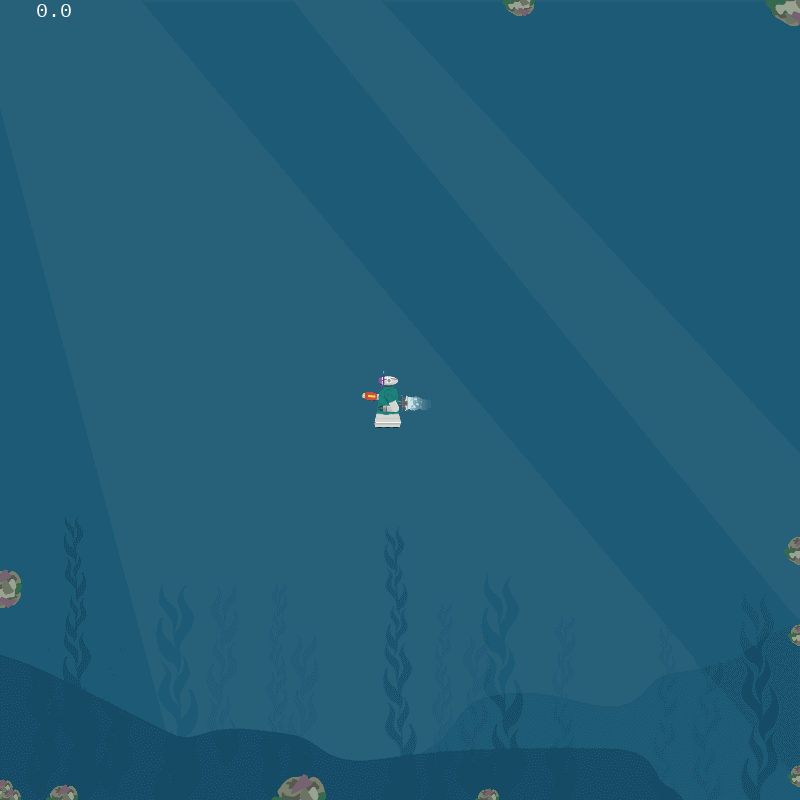

In [14]:
#STEP 3.4

# Pause on the last image
last_image = images[-1]
for i in range(100):
  images.append(last_image)

# Save the images as a gif
images[0].save('game_animation.gif',
               save_all=True,
               append_images=images[1:],
               optimize = True,
               duration=10,
               loop=0)

# Open and view the previous top specimen as a video
with open('game_animation.gif','rb') as f:
    IPython.display.display(IPython.display.Image(data=f.read(), format='png'))

You should rerun STEP 3.3 many times until you get a John-Green-bot that performs well. Learning over many trial-and-error runs is a critical part of reinforcement learning and especially genetic algorithms.

###Visualize the neural network

Ultimately, we're creating and training a neural network for John-Green-bot, and we can visualize it. Weak connections (lower weights) are white and strong connections (higher weights) are shown in red.

It's tough to pick apart from this image, but this neural network basically encodes actions like "run away from trash," "don't waste blasts," and "destroy the trash" as weights.

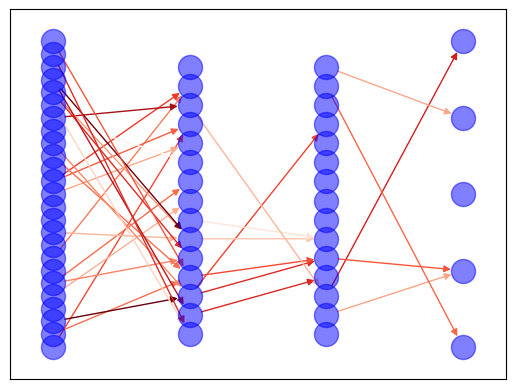

In [15]:
#STEP 3.5

net = generation[0]
G=nx.DiGraph()

# Build nodes
for i in range(net.inputLayer.shape[0]):
  G.add_node("i{}".format(i),pos=(0,i))
for i in range(net.inputLayer.shape[1]):
  G.add_node("h{}".format(i),pos=(1,1.5*i+1))
for i in range(net.outputLayer.shape[0]):
  G.add_node("h2{}".format(i),pos=(2,1.5*i+1))
for i in range(net.outputLayer.shape[1]):
  G.add_node("o{}".format(i),pos=(3,6*i))

# Draw edges
for i in range(net.inputLayer.shape[0]):
  for j in range(net.inputLayer.shape[1]):
    G.add_edge("i{}".format(i), "h{}".format(j), weight=net.inputLayer[i][j])

for i in range(net.interLayers.shape[0]):
  for j in range(net.interLayers.shape[1]):
    G.add_edge("h{}".format(i), "h2{}".format(j), weight=net.interLayers[i][j][0])

for i in range(net.outputLayer.shape[0]):
  for j in range(net.outputLayer.shape[1]):
    G.add_edge("h2{}".format(i), "o{}".format(j), weight=net.outputLayer[i][j])

pos = nx.get_node_attributes(G,'pos')
edges = []
weights = []
for edge, weight in nx.get_edge_attributes(G,'weight').items():
  if weight != 0:
    edges.append(edge)
    weights.append(weight)
_= nx.draw_networkx_nodes(G, pos, node_color='b', alpha=0.5)
_= nx.draw_networkx_edges(G, pos, edgelist=edges, \
                          edge_color=weights, edge_cmap=plt.cm.Reds)